<a href="https://colab.research.google.com/github/WelfLowe/ML4developers/blob/main/3-Numerical_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression

Load necessary libraries.

In [67]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_california_housing

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.cm as cm

Load data:

In [40]:
housing_data = fetch_california_housing()

# Convert the data into a pandas DataFrame
df = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
df['Target'] = housing_data.target
print(df.columns)


Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'Target'],
      dtype='object')


1. MedInc: Median income in the block.
2. HouseAge: Median house age in the block.
3. AveRooms: Average number of rooms per household.
4. AveBedrms: Average number of bedrooms per household.
5. Population: Block population.
6. AveOccup: Average number of occupants per household.
7. Latitude: Block latitude.
8. Longitude: Block longitude.
9. Target: Median house value (in hundreds of thousands of dollars).

No missing datapoints:

In [41]:
df.isnull().sum()

,0
MedInc,0
HouseAge,0
AveRooms,0
AveBedrms,0
Population,0
AveOccup,0
Latitude,0
Longitude,0
Target,0


Select the 'AveRooms' and 'HouseAge' features as predictors:

In [66]:
X = pd.DataFrame(np.c_[df['AveOccup'], df['AveRooms']], columns = ['AveOccup','AveRooms'])
Y = df['Target']
X

,AveOccup,AveRooms
0,2.555556,6.984127
1,2.109842,6.238137
2,2.802260,8.288136
3,2.547945,5.817352
4,2.181467,6.281853
...,...,...
20635,2.560606,5.045455
20636,3.122807,6.114035
20637,2.325635,5.205543
20638,2.123209,5.329513


In [43]:
X.min(axis=0)

,0
AveOccup,0.692308
AveRooms,0.846154


In [44]:
X.max(axis=0)

,0
AveOccup,1243.333333
AveRooms,141.909091


Odd max values! Let's remove the outliers. (Here using Leverage statistics).

In [77]:
# Add a constant to the dataset (for the intercept in OLS regression)
X = sm.add_constant(df.drop('Target', axis=1))  # Features (with intercept)
y = df['Target']  # Target variable

# Fit an OLS model
model = sm.OLS(y, X).fit()

# Get leverage (hat) values from the model
influence = model.get_influence()
leverage = influence.hat_matrix_diag

# Define a threshold for high leverage (commonly 2 * (p+1) / n)
n = X.shape[0]  # Number of observations
p = X.shape[1] - 1  # Number of features
threshold = 2 * (p + 1) / n

# Identify high leverage points (outliers)
high_leverage_points = np.where(leverage > threshold)[0]

# Print the outliers based on leverage
outliers_df = df.iloc[high_leverage_points]
print(f"Number of outliers: {len(high_leverage_points)} ({len(high_leverage_points)/len(X)*100}%)")

# Eliminate outliers
df_no_outliers = df.drop(index=high_leverage_points)

Number of outliers: 803 (3.8905038759689923%)


In [79]:
X = df_no_outliers[['AveOccup', 'AveRooms']]
Y = df_no_outliers['Target']
X.max(axis=0)

,0
AveOccup,33.952941
AveRooms,14.189349


Still odd but OK for now.

Split training and test data:

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(15869, 2)
(3968, 2)
(15869,)
(3968,)


Fit the model:

In [81]:
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)

LinearRegression()

Evaluate the model using MSE and R-Squared.

- MSE represents the residual error which is nothing but sum of squared difference between actual values and the predicted / estimated values divided by total number of records.

- R-Squared represents the fraction of variance captured by the regression model.

- The disadvantage of using MSE is that the value of MSE varies based on whether the values of response variable is scaled or not. If scaled, MSE will be lower than the unscaled values.

In [82]:
# model evaluation for training set
y_train_predict = lr_model.predict(X_train)
mse = mean_squared_error(Y_train, y_train_predict)
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = lr_model.predict(X_test)
mse = mean_squared_error(Y_test, y_test_predict)
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
MSE is 1.0840313021407015
R2 score is 0.14310795892023265


The model performance for testing set
--------------------------------------
MSE is 1.0851877727571215
R2 score is 0.13301301134814014


In [83]:
def visualize(X, Y, model):
  x= X['AveOccup']
  y= X['AveRooms']
  z = Y

  N = 100
  x_pred = np.linspace(0.5, 34., N)   # N values in the range of LSTAT
  y_pred = np.linspace(0.5, 15., N)  # N values in the range of RM
  xx_pred, yy_pred = np.meshgrid(x_pred, y_pred)
  model_viz = np.array([xx_pred.flatten(), yy_pred.flatten()]).T
  model_vizz = pd.DataFrame(model_viz, columns = ['AveOccup','AveRooms'])

  predicted = model.predict(model_vizz)
  zz_pred = predicted.reshape(N,N)

  plt.style.use('default')

  fig = plt.figure(figsize=(12, 4))

  ax1 = fig.add_subplot(131, projection='3d')
  ax2 = fig.add_subplot(132, projection='3d')
  ax3 = fig.add_subplot(133, projection='3d')

  axes = [ax1, ax2, ax3]

  for ax in axes:
      surf = ax.plot_surface(xx_pred, yy_pred, zz_pred, cmap=cm.coolwarm, linewidth=0, antialiased=False)
      ax.plot(x, y, z, color='k', zorder=15, linestyle='none', marker='.', alpha=0.35)

      ax.set_xlabel('AveOccup')
      ax.set_ylabel('AveRooms')
      ax.set_zlabel('Target')

  ax1.view_init(elev=28, azim=120)
  ax2.view_init(elev=4, azim=114)
  ax3.view_init(elev=60, azim=165)
  fig.tight_layout(pad=2.5)
  fig.colorbar(surf, shrink=0.75, pad=0.15)


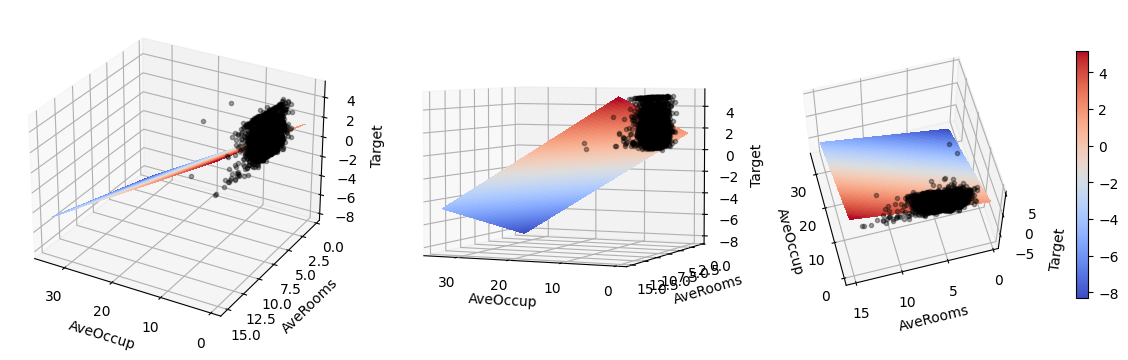

In [84]:
visualize(X_test, Y_test, lr_model)

# KNN Regression

KNN regression is an alternative approach to numerical regression.

In [85]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, Y_train)

KNeighborsRegressor()

In [86]:
# model evaluation for training set
y_train_predict = knn_model.predict(X_train)
mse = mean_squared_error(Y_train, y_train_predict)
r2 = r2_score(Y_train, y_train_predict)

print("The model performance for training set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))
print("\n")

# model evaluation for testing set
y_test_predict = knn_model.predict(X_test)
mse = mean_squared_error(Y_test, y_test_predict)
r2 = r2_score(Y_test, y_test_predict)

print("The model performance for testing set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 score is {}'.format(r2))

The model performance for training set
--------------------------------------
MSE is 0.7166567214631406
R2 score is 0.4335058041263292


The model performance for testing set
--------------------------------------
MSE is 1.107233857032007
R2 score is 0.11539977546686375


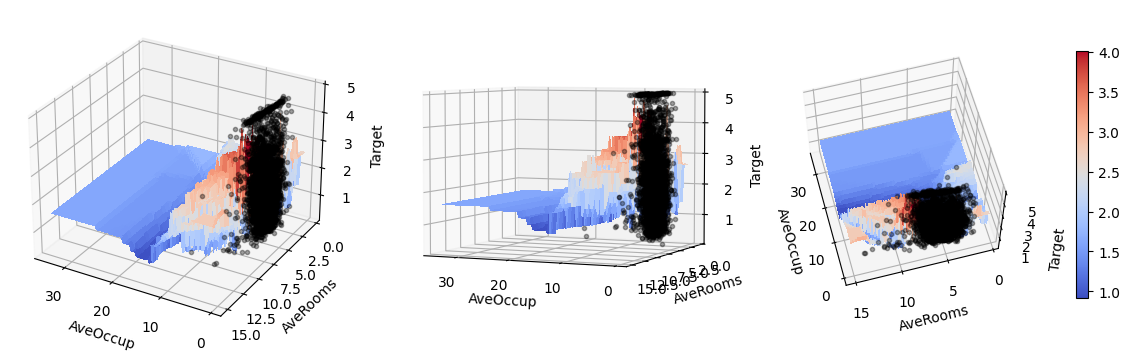

In [87]:
visualize(X_test, Y_test, knn_model)

# Advanced: Feature selection

Again all features and their values:

In [88]:
XX = df_no_outliers.drop('Target',axis=1)
XX

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


All features give a certain $R^2$ value (in training data in linear regressin).

In [89]:
XX_train, XX_test, YY_train, YY_test = train_test_split(XX, Y, test_size = 0.2, random_state=5)

In [90]:
def train_and_test(XX_train, XX_test, YY_train, YY_test):
  lr_model = LinearRegression()
  lr_model.fit(XX_train, YY_train)
  y_test_predict = lr_model.predict(XX_test)
  return r2_score(YY_test, y_test_predict)
  #return 1/mean_squared_error(YY_test, y_test_predict)


In [91]:
train_and_test(XX_train, XX_test, YY_train, YY_test)

0.6574905550883277

Less could be more, i.e., fewer features could lead to a better model. Feature selection tries to select the most relevant ones. This could be done in many ways. Two step-by-step, recursive approaches **eliminate** features from the full feature set and **agglomerate** features to the empty set, respectively.

Recursive elimination of features one by one until the $R^2$ statistics doesn't increase.

In [110]:
def eliminate(XX_train, XX_test, verbose):
  drop_col = ''
  r2_max = train_and_test(XX_train, XX_test, YY_train, YY_test)
  for (colname, _) in XX_train.items():
    XX_train_ = XX_train.drop(colname,axis=1)
    XX_test_ = XX_test.drop(colname,axis=1)
    r2 = train_and_test(XX_train_, XX_test_, YY_train, YY_test)
    if r2 >= r2_max:
      if verbose:
        print("maybe remove ",colname)
        print("R2 =", r2)
      drop_col = colname
      r2_max = r2
  if drop_col != '':
    if verbose:
      print("=>actually remove ",drop_col)
    XX_train_ = XX_train.drop(drop_col,axis=1)
    XX_test_ = XX_test.drop(drop_col,axis=1)
    res = eliminate(XX_train_, XX_test_, verbose)
  else:
    res = list(XX_train.columns)
  return res

In [111]:
features = eliminate(XX_train, XX_test, True)
print(features, len(features))

['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'] 8


Alternatively, by starting with the empty list of features and adding features as long as the $R^2$ statistics increases.

In [108]:
def agglomerate(selected_names, r2_max, verbose):
  add_col = ''
  for (colname, _) in XX_train.items():
    if not colname in selected_names:
      selected_names_=selected_names.copy()
      selected_names_.append(colname)
      XX_train_ = XX_train[selected_names_]
      XX_test_ = XX_test[selected_names_]
      r2 = train_and_test(XX_train_, XX_test_, YY_train, YY_test)
      if r2 >= r2_max:
        if verbose:
          print("maybe add ",colname)
          print("R2 =", r2)
        add_col = colname
        r2_max = r2

  if add_col != '':
    if verbose:
      print("=>actually add ", add_col)
    selected_names_=selected_names.copy()
    selected_names_.append(add_col)
    res = agglomerate(selected_names_, r2_max, verbose)
  else:
    res = selected_names
  return res

In [109]:
features = agglomerate([], 0, True)
print(features, len(features))

maybe add  MedInc
R2 = 0.462286533001524
=>actually add  MedInc
maybe add  HouseAge
R2 = 0.5088382595288469
=>actually add  HouseAge
maybe add  AveRooms
R2 = 0.5368869174376983
maybe add  AveOccup
R2 = 0.5474083357178796
=>actually add  AveOccup
maybe add  AveRooms
R2 = 0.5770582591097652
=>actually add  AveRooms
maybe add  AveBedrms
R2 = 0.6085385545662543
=>actually add  AveBedrms
maybe add  Population
R2 = 0.6095868125536945
maybe add  Latitude
R2 = 0.6115342107609546
=>actually add  Latitude
maybe add  Population
R2 = 0.6123269491560577
maybe add  Longitude
R2 = 0.6573653175074734
=>actually add  Longitude
maybe add  Population
R2 = 0.6574905550883313
=>actually add  Population
['MedInc', 'HouseAge', 'AveOccup', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude', 'Population'] 8
